# 3.5 Agent의 히스토리를 관리하는 방법

In [1]:
from dotenv import load_dotenv

load_dotenv(dotenv_path="../.env")

True

In [2]:
from langchain_ollama import ChatOllama
from langchain_openai import ChatOpenAI

# llm = ChatOllama(model="llama3.1")
llm = ChatOpenAI(model="gpt-4o-mini")

c:\Users\a1ljm\Desktop\ANSWER_25\inflearn-langgraph-agent\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from langchain_core.tools import tool

@tool
def add(a: int, b: int) -> int:
    """숫자 a와 b를 더합니다."""
    return a+b

@tool
def mul(a: int, b: int) -> int:
    """숫자 a와 b를 곱합니다."""
    return a*b

```python
tools = [add, mul, retriever_tool] + search_tools + arxiv_tools + gmail_tools
```

In [4]:
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_chroma import Chroma
from langchain_core.tools.retriever import create_retriever_tool

collection_name = "real_estate_tax"
embedding_function = HuggingFaceEmbeddings(model="BAAI/bge-m3")
vector_store = Chroma(
    collection_name=collection_name,
    embedding_function=embedding_function,
    persist_directory="./chroma"
)
retriever = vector_store.as_retriever(search_kwargs={"k": 3})
retriever_tool = create_retriever_tool(
    retriever=retriever,
    name="real_estate_tax_retriever",
    description="부동산 세금 정보 검색기"
)
retriever_tool

StructuredTool(name='real_estate_tax_retriever', description='부동산 세금 정보 검색기', args_schema=<class 'langchain_core.tools.retriever.RetrieverInput'>, func=<function create_retriever_tool.<locals>.func at 0x000001E7FBF47740>, coroutine=<function create_retriever_tool.<locals>.afunc at 0x000001E7FBF45EE0>)

In [5]:
from langchain_tavily import TavilySearch
from langchain_community.tools import DuckDuckGoSearchRun

search_tools = [
    DuckDuckGoSearchRun(),
    TavilySearch(
        max_results=3,
        topic="general",  # "news", "finance"
        include_answer=True,
        include_raw_content=True,
        include_images=True,
        include_image_descriptions=True,
        search_depth="advanced",  # "basic"
    )
]
search_tools

c:\Users\a1ljm\Desktop\ANSWER_25\inflearn-langgraph-agent\.venv\Lib\site-packages\langchain_tavily\tavily_research.py:97: UserWarning: Field name "output_schema" in "TavilyResearch" shadows an attribute in parent "BaseTool"
  class TavilyResearch(BaseTool):  # type: ignore[override, override]
c:\Users\a1ljm\Desktop\ANSWER_25\inflearn-langgraph-agent\.venv\Lib\site-packages\langchain_tavily\tavily_research.py:97: UserWarning: Field name "stream" in "TavilyResearch" shadows an attribute in parent "BaseTool"
  class TavilyResearch(BaseTool):  # type: ignore[override, override]


[DuckDuckGoSearchRun(api_wrapper=DuckDuckGoSearchAPIWrapper(region='wt-wt', safesearch='moderate', time='y', max_results=5, backend='auto', source='text')),
 TavilySearch(search_depth='advanced', include_images=True, max_results=3, topic='general', include_answer=True, include_raw_content=True, include_image_descriptions=True, api_wrapper=TavilySearchAPIWrapper(tavily_api_key=SecretStr('**********'), api_base_url=None))]

In [6]:
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper

arxiv_tools = [
    ArxivQueryRun(api_wrapper=ArxivAPIWrapper(top_k_results=3)),
    WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(top_k_results=3)),
]
arxiv_tools

[ArxivQueryRun(api_wrapper=ArxivAPIWrapper(arxiv_search=<class 'arxiv.Search'>, arxiv_exceptions=(<class 'arxiv.ArxivError'>, <class 'arxiv.UnexpectedEmptyPageError'>, <class 'arxiv.HTTPError'>), top_k_results=3, ARXIV_MAX_QUERY_LENGTH=300, continue_on_failure=False, load_max_docs=100, load_all_available_meta=False, doc_content_chars_max=4000)),
 WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(wiki_client=<module 'wikipedia' from 'c:\\Users\\a1ljm\\Desktop\\ANSWER_25\\inflearn-langgraph-agent\\.venv\\Lib\\site-packages\\wikipedia\\__init__.py'>, top_k_results=3, lang='en', load_all_available_meta=False, doc_content_chars_max=4000))]

In [7]:
from langchain_google_community import GmailToolkit
from langchain_google_community.gmail.utils import get_google_credentials, build_gmail_service

credentials = get_google_credentials(
    scopes=["https://mail.google.com/"],
    token_file="./google/gmail_token.json",
    client_secrets_file="./google/gmail_credentials.json"
)
api_resource = build_gmail_service(credentials=credentials)
gmail_toolkit = GmailToolkit(api_resource=api_resource)
gmail_tools = gmail_toolkit.get_tools()
gmail_tools

[GmailCreateDraft(api_resource=<googleapiclient.discovery.Resource object at 0x000001E7813E0470>),
 GmailSendMessage(api_resource=<googleapiclient.discovery.Resource object at 0x000001E7813E0470>),
 GmailSearch(api_resource=<googleapiclient.discovery.Resource object at 0x000001E7813E0470>),
 GmailGetMessage(api_resource=<googleapiclient.discovery.Resource object at 0x000001E7813E0470>),
 GmailGetThread(api_resource=<googleapiclient.discovery.Resource object at 0x000001E7813E0470>)]

In [8]:
from langgraph.prebuilt import ToolNode

tools = [add, mul, retriever_tool] + search_tools + arxiv_tools + gmail_tools
llm_with_tools = llm.bind_tools(tools=tools)

tool_node = ToolNode(tools=tools)
tool_node._tools_by_name

{'add': StructuredTool(name='add', description='숫자 a와 b를 더합니다.', args_schema=<class 'langchain_core.utils.pydantic.add'>, func=<function add at 0x000001E7D5567740>),
 'mul': StructuredTool(name='mul', description='숫자 a와 b를 곱합니다.', args_schema=<class 'langchain_core.utils.pydantic.mul'>, func=<function mul at 0x000001E7D55654E0>),
 'real_estate_tax_retriever': StructuredTool(name='real_estate_tax_retriever', description='부동산 세금 정보 검색기', args_schema=<class 'langchain_core.tools.retriever.RetrieverInput'>, func=<function create_retriever_tool.<locals>.func at 0x000001E7FBF47740>, coroutine=<function create_retriever_tool.<locals>.afunc at 0x000001E7FBF45EE0>),
 'duckduckgo_search': DuckDuckGoSearchRun(api_wrapper=DuckDuckGoSearchAPIWrapper(region='wt-wt', safesearch='moderate', time='y', max_results=5, backend='auto', source='text')),
 'tavily_search': TavilySearch(search_depth='advanced', include_images=True, max_results=3, topic='general', include_answer=True, include_raw_content=True, 

In [9]:
from langgraph.graph import MessagesState, StateGraph

class AgentState(MessagesState):
    summary: str

workflow = StateGraph(AgentState)

In [10]:
from langchain_core.messages import SystemMessage

def agent(state: AgentState) -> AgentState:
    """
    주어진 'state'에서 메시지를 가져와, LLM과 도구를 사용하여 응답 메시지를 생성합니다.
    Args:
        state (AgentState): 메시지 기록과 요약을 포함하는 state
    Returns:
        AgentState: 응답 메시지를 포함하는 새로운 state
    """
    messages = state["messages"]
    summary = state["summary"]

    if summary != "":
        messages = [SystemMessage(content=f"이전 대화 기록 요약입니다: {summary}")] + messages
    
    response = llm_with_tools.invoke(messages)

    return {"messages": [response]}

In [11]:
def summarize_messages(state: AgentState) -> AgentState:
    """
    주어진 state의 메시지를 요약합니다.
    Args:
        state (AgentState): 요약과 메시지를 포함하는 state
    Returns:
        AgentState: 요약된 메시지를 포함하는 state
    """
    messages = state["messages"]
    summary = state["summary"]

    if summary == "":
        summary_prompt = f"""아래 대화 기록을 요약해 주세요:
            chat_history: {messages}"""
    else:
        summary_prompt = f"""이전 요약을 포함해서 아래 대화 기록을 요약해 주세요:
            chat_history: {messages}
            summary: {summary}"""
    
    summary = llm_with_tools.invoke(summary_prompt)
    return {"summary": summary.content}

In [12]:
from langchain_core.messages import RemoveMessage

def delete_messages(state: AgentState) -> AgentState:
    """
    주어진 state에서 오래된 메시지를 삭제합니다.
    Args:
        state (AgentState): 메시지를 포함하는 state
    Returns:
        AgentState: 삭제된 메시지를 포함하는 새로운 state
    """
    messages = state["messages"]
    deleted_messages = [RemoveMessage(id=message.id) for message in messages[:-3]]
    return {"messages": deleted_messages}

In [ ]:
from typing import Literal

def should_continue(state: AgentState) -> Literal["tools", "summarize_messages"]:
    """
    주어진 state에 따라 다음 단계로 진행할지 결정합니다.
    Args:
        state (AgentState): 메시지와 도구 호출 정보를 포함하는 state
    Returns:
        Literal["tools", "summarize_messages"]: 다음 단계로 "tools" or "summarize_messages"를 반환합니다.
    """
    messages = state["messages"]
    if messages[-1].tool_calls:
        return "tools"
    return "summarize_messages"

In [14]:
from langgraph.graph import START, END

workflow.add_node("agent", agent)
workflow.add_node("tools", tool_node)
workflow.add_node("summarize_messages", summarize_messages)
workflow.add_node("delete_messages", delete_messages)

workflow.add_edge(START, "agent")
workflow.add_conditional_edges("agent", should_continue, ["tools", "summarize_messages"])
workflow.add_edge("tools", "agent")
workflow.add_edge("summarize_messages", "delete_messages")
workflow.add_edge("delete_messages", END)

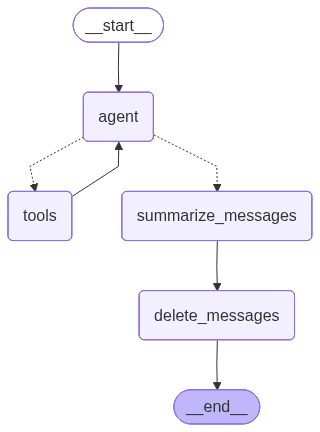

In [15]:
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import display, Image

checkpointer = MemorySaver()
graph = workflow.compile(checkpointer=checkpointer)
display(Image(graph.get_graph().draw_mermaid_png()))

In [16]:
from langchain_core.messages import HumanMessage

config = {
    "configurable": {
        "thread_id": "summarize_paper"
    }
}

In [24]:
query = "limjangmook@gmail.com으로 Attention Is All You Need 논문을 요약해서 이메일 초안을 작성해주세요"

for response in graph.stream({"messages": [HumanMessage(query)], "summary": ""}, config=config, stream_mode="values"):
    response["messages"][-1].pretty_print()

================================ Human Message =================================

limjangmook@gmail.com으로 Attention Is All You Need 논문을 요약해서 이메일 초안을 작성해주세요
================================== Ai Message ==================================
Tool Calls:
  create_gmail_draft (call_envmp5rDukYRxofVt3fpWhG6)
 Call ID: call_envmp5rDukYRxofVt3fpWhG6
  Args:
    message: 안녕하세요,

아래는 "Attention Is All You Need" 논문에 대한 요약입니다.

**요약:**  
"Attention Is All You Need" 논문은 트랜스포머 아키텍처를 소개하였으며, 이는 머신 러닝에서 주목할 만한 혁신으로 작용하고 있습니다. 이 아키텍처는 주로 자연어 처리(NLP)와 같은 다양한 작업에서 뛰어난 성능을 발휘합니다. 트랜스포머는 전통적인 순환 신경망(RNN)과는 달리 전적으로 주의 메커니즘만을 사용하여 입력 데이터의 모든 단어(혹은 토큰) 간의 관계를 효율적으로 모델링합니다. 이를 통해 트랜스포머는 긴 의존성을 효과적으로 처리할 수 있으며, 병렬 처리가 가능하여 훈련 속도를 크게 향상시킵니다.

이 논문은 특히 다중 주의 헤드를 활용하여 정보의 다양한 표현을 동시에 학습할 수 있는 점을 강조합니다. 또한, 여러 가지 실험을 통해 이 아키텍처의 효과를 검증하고, 다른 기법들과 비교하여 상대적으로 우수한 성능을 보임을 입증하였습니다.

이 논문은 후속 연구에 많은 영감을 주었으며, 자연어 처리의 발전에 기여하였습니다.

**출처:** [Attention Is All You Need (arXiv)](https://arxiv.org/abs/1706.03762)

감사합니다.
    to:

In [25]:
graph.get_state(config).values["messages"]

[AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 373, 'prompt_tokens': 2376, 'total_tokens': 2749, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 1792}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_29330a9688', 'id': 'chatcmpl-CqVnw6AmmTSgI2FGItdSC1aRiCvFe', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019b536f-1b1f-7641-a57c-d067a85b5b22-0', tool_calls=[{'name': 'create_gmail_draft', 'args': {'message': '안녕하세요,\n\n아래는 "Attention Is All You Need" 논문에 대한 요약입니다.\n\n**요약:**  \n"Attention Is All You Need" 논문은 트랜스포머 아키텍처를 소개하였으며, 이는 머신 러닝에서 주목할 만한 혁신으로 작용하고 있습니다. 이 아키텍처는 주로 자연어 처리(NLP)와 같은 다양한 작업에서 뛰어난 성능을 발휘합니다. 트랜스포머는 전통적인 순환 신경망(RNN)과는 달리 전적으로 주의 메커니즘만을 사용하여 입력 데이터의 모든 단어(혹은 토큰)

In [26]:
graph.get_state(config).values["summary"]

'대화 요약:\n\n사용자는 "Attention Is All You Need" 논문에 대한 요약을 limjangmook@gmail.com으로 이메일로 보내달라고 요청했습니다. AI는 논문의 주요 내용을 요약하여 이메일 초안을 작성하고, 이를 성공적으로 전송했습니다. 요약 내용은 트랜스포머 아키텍처의 혁신성과 자연어 처리에서의 성능을 강조하며, 이 논문이 후속 연구에 미친 영향을 논의하고 있습니다. 이메일 전송이 완료되었다는 확인 메시지도 전달되었습니다.'

In [27]:
update_query = "논문의 출처 URL을 포함해 주세요"

for response in graph.stream({"messages": [HumanMessage(update_query)]}, config=config, stream_mode="values"):
    response["messages"][-1].pretty_print()

================================ Human Message =================================

논문의 출처 URL을 포함해 주세요
================================== Ai Message ==================================
Tool Calls:
  create_gmail_draft (call_VWUBnISyibwahKYEd4ehJ2P9)
 Call ID: call_VWUBnISyibwahKYEd4ehJ2P9
  Args:
    message: 안녕하세요,

아래는 "Attention Is All You Need" 논문에 대한 요약입니다.

**요약:**  
"Attention Is All You Need" 논문은 트랜스포머 아키텍처를 소개하였으며, 이는 머신 러닝에서 주목할 만한 혁신으로 작용하고 있습니다. 이 아키텍처는 주로 자연어 처리(NLP)와 같은 다양한 작업에서 뛰어난 성능을 발휘합니다. 트랜스포머는 전통적인 순환 신경망(RNN)과는 달리 전적으로 주의 메커니즘만을 사용하여 입력 데이터의 모든 단어(혹은 토큰) 간의 관계를 효율적으로 모델링합니다. 이를 통해 트랜스포머는 긴 의존성을 효과적으로 처리할 수 있으며, 병렬 처리가 가능하여 훈련 속도를 크게 향상시킵니다.

이 논문은 특히 다중 주의 헤드를 활용하여 정보의 다양한 표현을 동시에 학습할 수 있는 점을 강조합니다. 또한, 여러 가지 실험을 통해 이 아키텍처의 효과를 검증하고, 다른 기법들과 비교하여 상대적으로 우수한 성능을 보임을 입증하였습니다.

이 논문은 후속 연구에 많은 영감을 주었으며, 자연어 처리의 발전에 기여하였습니다.

**출처:** [Attention Is All You Need (arXiv)](https://arxiv.org/abs/1706.03762)

감사합니다.
    to: ['limjangmook@gmail.com']
    subject: Attention Is A

In [28]:
graph.get_state(config).values["messages"]

[AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 373, 'prompt_tokens': 2523, 'total_tokens': 2896, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_29330a9688', 'id': 'chatcmpl-CqVoB2h3eRJUVJqr8liFmjWCq2KCq', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019b536f-591b-7f12-b286-66b444be562b-0', tool_calls=[{'name': 'create_gmail_draft', 'args': {'message': '안녕하세요,\n\n아래는 "Attention Is All You Need" 논문에 대한 요약입니다.\n\n**요약:**  \n"Attention Is All You Need" 논문은 트랜스포머 아키텍처를 소개하였으며, 이는 머신 러닝에서 주목할 만한 혁신으로 작용하고 있습니다. 이 아키텍처는 주로 자연어 처리(NLP)와 같은 다양한 작업에서 뛰어난 성능을 발휘합니다. 트랜스포머는 전통적인 순환 신경망(RNN)과는 달리 전적으로 주의 메커니즘만을 사용하여 입력 데이터의 모든 단어(혹은 토큰) 간의

In [29]:
graph.get_state(config).values["summary"]

'대화 요약:\n\n사용자는 "Attention Is All You Need" 논문에 대한 요약을 limjangmook@gmail.com으로 이메일로 보내달라고 요청했습니다. AI는 논문의 주요 내용을 요약하여 이메일 초안을 작성했습니다. 요약은 트랜스포머 아키텍처의 혁신성과 자연어 처리에서의 성능을 강조하며, 이 논문이 후속 연구에 미친 영향을 논의하고 있습니다. 이후 사용자는 논문의 출처 URL을 포함해 달라고 요청하였고, AI는 URL을 추가한 이메일 초안을 다시 작성했습니다. 이메일 전송이 완료되었다는 확인 메시지도 전달되었습니다.'

In [30]:
send_query = "이메일 초안을 전송해 주세요"

for response in graph.stream({"messages": [HumanMessage(send_query)]}, config=config, stream_mode="values"):
    response["messages"][-1].pretty_print()

================================ Human Message =================================

이메일 초안을 전송해 주세요
================================== Ai Message ==================================
Tool Calls:
  send_gmail_message (call_2PeHWCaCBKrG29Y8Xh2FZPxN)
 Call ID: call_2PeHWCaCBKrG29Y8Xh2FZPxN
  Args:
    message: 안녕하세요,

아래는 "Attention Is All You Need" 논문에 대한 요약입니다.

**요약:**  
"Attention Is All You Need" 논문은 트랜스포머 아키텍처를 소개하였으며, 이는 머신 러닝에서 주목할 만한 혁신으로 작용하고 있습니다. 이 아키텍처는 주로 자연어 처리(NLP)와 같은 다양한 작업에서 뛰어난 성능을 발휘합니다. 트랜스포머는 전통적인 순환 신경망(RNN)과는 달리 전적으로 주의 메커니즘만을 사용하여 입력 데이터의 모든 단어(혹은 토큰) 간의 관계를 효율적으로 모델링합니다. 이를 통해 트랜스포머는 긴 의존성을 효과적으로 처리할 수 있으며, 병렬 처리가 가능하여 훈련 속도를 크게 향상시킵니다.

이 논문은 특히 다중 주의 헤드를 활용하여 정보의 다양한 표현을 동시에 학습할 수 있는 점을 강조합니다. 또한, 여러 가지 실험을 통해 이 아키텍처의 효과를 검증하고, 다른 기법들과 비교하여 상대적으로 우수한 성능을 보임을 입증하였습니다.

이 논문은 후속 연구에 많은 영감을 주었으며, 자연어 처리의 발전에 기여하였습니다.

**출처:** [Attention Is All You Need (arXiv)](https://arxiv.org/abs/1706.03762)

감사합니다.
    to: ['limjangmook@gmail.com']
    subject: Attention Is All Y